In [17]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import polars as pl
import numpy as np

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [18]:
class CONFIG:
    seed = 42
    target_col = "responder_6"
    feature_cols = ["symbol_id", "time_id"] \
        + [f"feature_{idx:02d}" for idx in range(79)] \
        + [f"responder_{idx}_lag_1" for idx in range(9)]
    
train = pl.scan_parquet("/kaggle/input/js24-preprocessing-create-lags/training.parquet").collect().to_pandas()
valid = pl.scan_parquet("/kaggle/input/js24-preprocessing-create-lags/validation.parquet").collect().to_pandas()
train = pd.concat([train, valid]).reset_index(drop=True)

In [35]:
import xgboost as xgb  # Import the XGBoost library

def get_model(seed):
    # XGBoost parameters
    XGB_Params = {
        'learning_rate': 0.05,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 1,
        'reg_lambda': 5,
        'random_state': seed,
        'tree_method': 'gpu_hist',
        'n_gpus': 1,
        'objective': 'reg:squarederror',  # Specify the objective function
        'eval_metric': 'rmse',          # Optional: Specify evaluation metric
    }
    return XGB_Params

# Prepare training and validation data
X_train = train[CONFIG.feature_cols]
y_train = train[CONFIG.target_col]
w_train = train["weight"]

X_valid = valid[CONFIG.feature_cols]
y_valid = valid[CONFIG.target_col]
w_valid = valid["weight"]

# Create DMatrix objects for training and validation
Xy_train = xgb.DMatrix(X_train, label=y_train, weight=w_train)
Xy_valid = xgb.DMatrix(X_valid, label=y_valid, weight=w_valid)



In [ ]:
import gc
gc.collect()

In [ ]:
# Get model parameters
params = get_model(CONFIG.seed)

# Number of boosting rounds
num_boost_round = 2000

# Train the model using xgboost.train
evals = [(Xy_train, 'train'), (Xy_valid, 'valid')]
model = xgb.train(
    params=params,
    dtrain=Xy_train,
    num_boost_round=num_boost_round,
    evals=evals,
    early_stopping_rounds=50,  # Optional: Enable early stopping
    verbose_eval=True          # Optional: Display training progress
)

In [36]:
from sklearn.metrics import r2_score
y_pred_valid = model.predict(Xy_valid)
valid_score = r2_score(y_valid, y_pred_valid, sample_weight=w_valid )
valid_score

0.027356743812561035

symbol_id = 0, y_means = -0.00257
symbol_id = 1, y_means = -0.00372
symbol_id = 2, y_means = -0.00027
symbol_id = 3, y_means = 0.00263
symbol_id = 4, y_means = 0.00315
symbol_id = 5, y_means = -0.00458
symbol_id = 6, y_means = 0.00236
symbol_id = 7, y_means = -0.00109
symbol_id = 8, y_means = 0.00111
symbol_id = 9, y_means = -0.02493
symbol_id = 10, y_means = 0.00221
symbol_id = 11, y_means = -0.00213
symbol_id = 12, y_means = -0.00900
symbol_id = 13, y_means = -0.00105
symbol_id = 14, y_means = -0.00321
symbol_id = 15, y_means = 0.00109
symbol_id = 16, y_means = 0.00085
symbol_id = 17, y_means = 0.00070
symbol_id = 18, y_means = 0.00169
symbol_id = 19, y_means = 0.00043
symbol_id = 20, y_means = -0.00376
symbol_id = 21, y_means = -0.00393
symbol_id = 22, y_means = -0.00461
symbol_id = 23, y_means = 0.00686
symbol_id = 24, y_means = -0.00810
symbol_id = 25, y_means = -0.01133
symbol_id = 26, y_means = 0.00131
symbol_id = 27, y_means = -0.00458
symbol_id = 28, y_means = -0.00149
symbol_

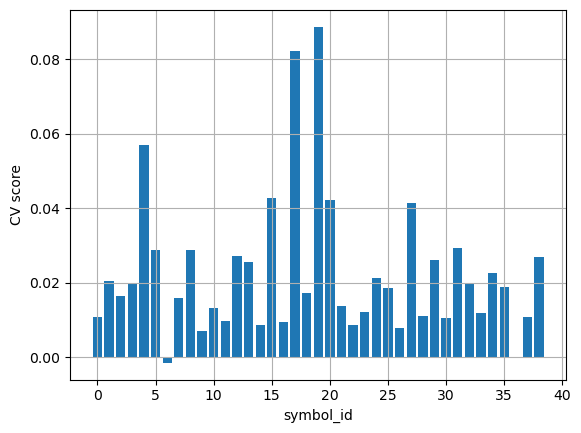

In [38]:
from matplotlib import pyplot as plt


y_means = { symbol_id : -1 for symbol_id in range(39) }
for symbol_id, gdf in train[["symbol_id", CONFIG.target_col]].groupby("symbol_id"):
    y_mean = gdf[ CONFIG.target_col ].mean()
    y_means[symbol_id] = y_mean
    print(f"symbol_id = {symbol_id}, y_means = {y_mean:.5f}")
    
cv_detail = { symbol_id : 0 for symbol_id in range(39) }
for symbol_id, gdf in valid.groupby("symbol_id"):
    X_valid = gdf[ CONFIG.feature_cols ]
    y_valid = gdf[ CONFIG.target_col ]
    w_valid = gdf[ "weight" ]
    Xy_valid = xgb.DMatrix(X_valid, label=y_valid, weight=w_valid)
    y_pred_valid = model.predict(Xy_valid)
    score = r2_score(y_valid, y_pred_valid, sample_weight=w_valid)
    cv_detail[symbol_id] = score
    
    print(f"symbol_id = {symbol_id}, score = {score:.5f}")
    
sids = list(cv_detail.keys())
plt.bar(sids, [cv_detail[sid] for sid in sids])
plt.grid()
plt.xlabel("symbol_id")
plt.ylabel("CV score")
plt.show()

In [40]:
import os
import dill

result = {
    "model" : model,
    "cv" : valid_score,
    "cv_detail" : cv_detail,
    "y_mean" : y_means,
}
os.makedirs('./modelxgb', exist_ok=True)
with open("./modelxgb/xgb_result.dill", "wb") as fp:
    dill.dump(result, fp)